In [32]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D,Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# ================================
# 1. CARGA Y PROCESAMIENTO DEL DATASET
# ================================

dataset_path = r"/content/drive/MyDrive/Trabajo de Grado/UCMerced_LandUse/Images"
nclases = 21
img_size = (256, 256)

X = []
y = []
clase_dict = {}

for idx, clase in enumerate(sorted(os.listdir(dataset_path))):
    clase_path = os.path.join(dataset_path, clase)
    if os.path.isdir(clase_path):
        clase_dict[idx] = clase
        for img_name in os.listdir(clase_path):
            img_path = os.path.join(clase_path, img_name)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img)
                X.append(img_array)
                y.append(idx)
            except Exception as e:
                print(f"Error cargando imagen {img_path}: {e}")

X = np.array(X).astype('float32') / 255.0
y = np.array(y)

# División 80-10-10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# One-hot encoding
y_train_cat = to_categorical(y_train, nclases)
y_val_cat = to_categorical(y_val, nclases)
y_test_cat = to_categorical(y_test, nclases)

print(f"Training data shape: {X_train.shape}, {y_train_cat.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val_cat.shape}")
print(f"Test data shape: {X_test.shape}, {y_test_cat.shape}")

Training data shape: (1680, 256, 256, 3), (1680, 21)
Validation data shape: (210, 256, 256, 3), (210, 21)
Test data shape: (210, 256, 256, 3), (210, 21)


In [37]:
# ================================
# 2. DEFINICIÓN DEL MODELO CNN
# ================================

cnn = Sequential([
    # Bloque 1
    Conv2D(64, (3, 3), activation='relu', padding='same',
           input_shape=(256, 256, 3),
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloque 2
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Bloque 3
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Global Average Pooling en vez de Flatten
    GlobalAveragePooling2D(),

    # Capas densas
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(21, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# ================================
# 3. ENTRENAMIENTO DEL MODELO
# ================================

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

history = cnn.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_val, y_val_cat),
    epochs=500,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 61s 890ms/step - accuracy: 0.1076 - loss: 4.8612 - val_accuracy: 0.0524 - val_loss: 5.2698 - learning_rate: 0.0010
Epoch 2/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 621ms/step - accuracy: 0.2065 - loss: 4.0915 - val_accuracy: 0.0667 - val_loss: 6.2773 - learning_rate: 0.0010
Epoch 3/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 627ms/step - accuracy: 0.2894 - loss: 3.6521 - val_accuracy: 0.0476 - val_loss: 7.5747 - learning_rate: 0.0010
Epoch 4/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 618ms/step - accuracy: 0.3351 - loss: 3.3786 - val_accuracy: 0.0429 - val_loss: 6.6075 - learning_rate: 0.0010
Epoch 5/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 630ms/step - accuracy: 0.3519 - loss: 3.1699 - val_accuracy: 0.0619 - val_loss: 9.7710 - learning_rate: 0.0010
Epoch 6/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 619ms/step - accuracy: 0.3843 - loss: 3.0495 - val_accuracy: 0.0810 - val_loss: 6.0514 - learning_rate: 0.0010
Epoch 7/500
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 632ms/step - accuracy: 0.4167 - l

In [38]:
# ================================
# 4. EVALUACIÓN DEL MODELO
# ================================

train_loss, train_accuracy = cnn.evaluate(X_train, y_train_cat)
val_loss, val_accuracy = cnn.evaluate(X_val, y_val_cat)
test_loss, test_accuracy = cnn.evaluate(X_test, y_test_cat)

print(f"\nTraining Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.9486 - loss: 0.8553
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8993 - loss: 1.0341
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.8952 - loss: 0.9888

Training Accuracy: 94.82%
Validation Accuracy: 87.62%
Test Accuracy: 89.52%


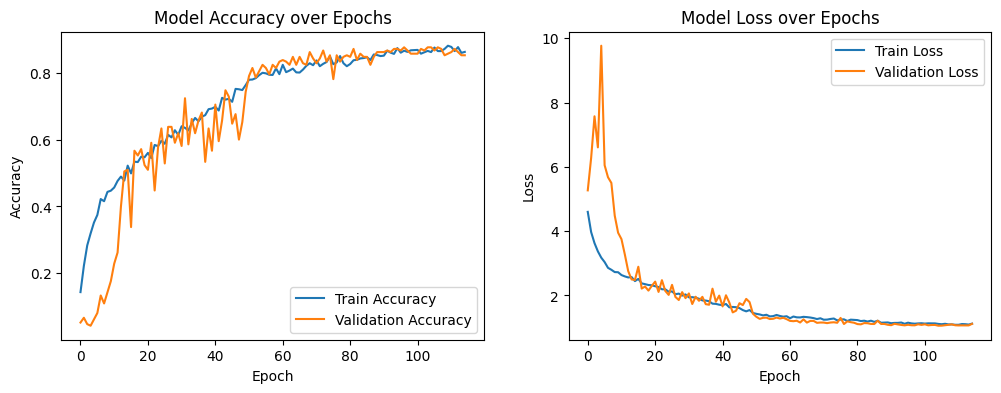

In [39]:
# ================================
# 5. GRÁFICAS DE ENTRENAMIENTO
# ================================

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step


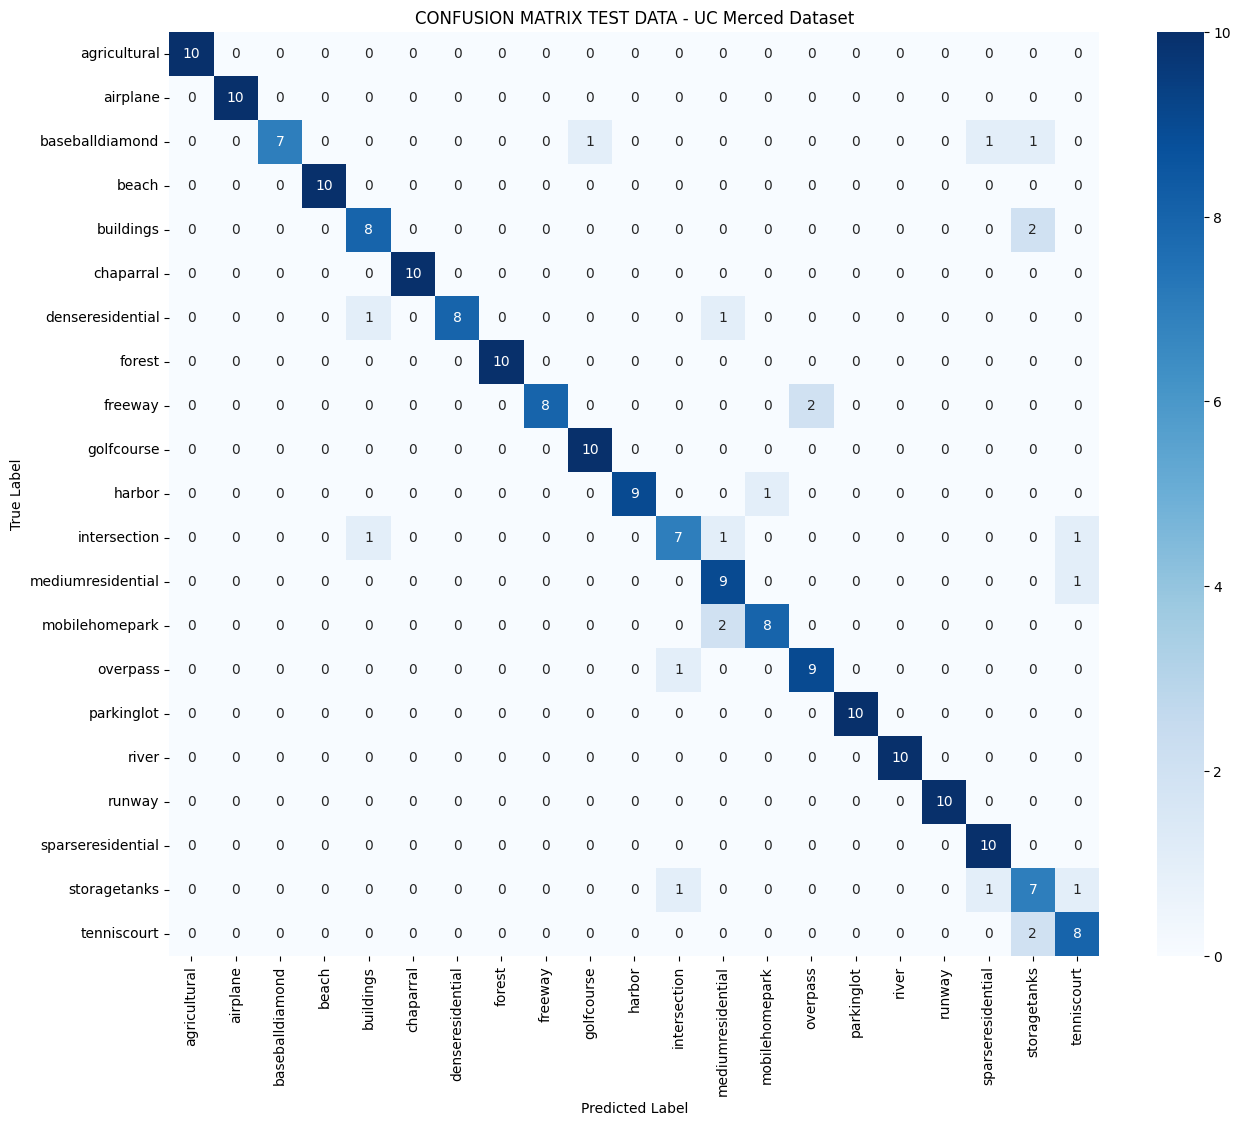

In [40]:
# ================================
# 6. MATRIZ DE CONFUSIÓN DATOS DE TESTEO
# ================================

y_pred = np.argmax(cnn.predict(X_test), axis=-1)
y_true = np.argmax(y_test_cat, axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(clase_dict.values()),
            yticklabels=list(clase_dict.values()))
plt.title('CONFUSION MATRIX TEST DATA - UC Merced Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


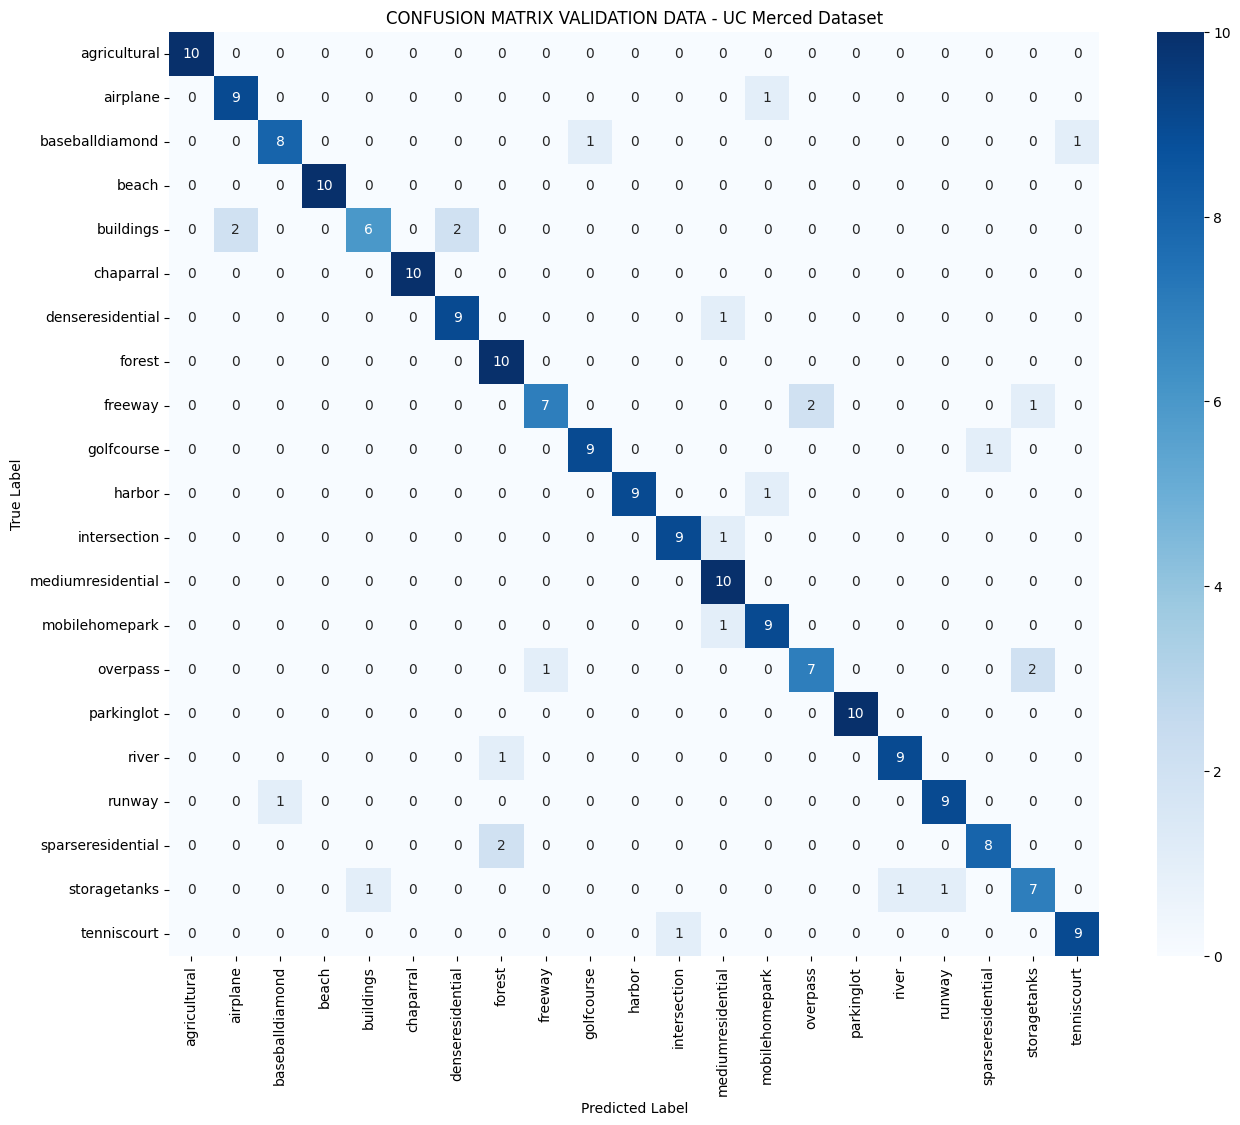

In [41]:
# ================================
# 7. MATRIZ DE CONFUSIÓN DATOS DE VALIDACIÓN
# ================================

y_pred = np.argmax(cnn.predict(X_val), axis=-1)
y_true = np.argmax(y_val_cat, axis=-1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(clase_dict.values()),
            yticklabels=list(clase_dict.values()))
plt.title('CONFUSION MATRIX VALIDATION DATA - UC Merced Dataset')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [43]:
# ================================
# 7. PRECISIÓN POR CLASE
# ================================

print("\nAccuracy por clase:")
for i in range(nclases):
    mask = (y_true == i)
    if np.sum(mask) > 0:
        acc = accuracy_score(y_true[mask], y_pred[mask])
        print(f"{clase_dict[i]}: {acc*100:.2f}%")


Accuracy por clase:
agricultural: 100.00%
airplane: 90.00%
baseballdiamond: 80.00%
beach: 100.00%
buildings: 60.00%
chaparral: 100.00%
denseresidential: 90.00%
forest: 100.00%
freeway: 70.00%
golfcourse: 90.00%
harbor: 90.00%
intersection: 90.00%
mediumresidential: 100.00%
mobilehomepark: 90.00%
overpass: 70.00%
parkinglot: 100.00%
river: 90.00%
runway: 90.00%
sparseresidential: 80.00%
storagetanks: 70.00%
tenniscourt: 90.00%


In [44]:
from sklearn.metrics import classification_report

y_pred = np.argmax(cnn.predict(X_val), axis=-1)
y_true = np.argmax(y_val_cat, axis=-1)

print(classification_report(
    y_true, y_pred,
    target_names=list(clase_dict.values())
))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
                   precision    recall  f1-score   support

     agricultural       1.00      1.00      1.00        10
         airplane       0.82      0.90      0.86        10
  baseballdiamond       0.89      0.80      0.84        10
            beach       1.00      1.00      1.00        10
        buildings       0.86      0.60      0.71        10
        chaparral       1.00      1.00      1.00        10
 denseresidential       0.82      0.90      0.86        10
           forest       0.77      1.00      0.87        10
          freeway       0.88      0.70      0.78        10
       golfcourse       0.90      0.90      0.90        10
           harbor       1.00      0.90      0.95        10
     intersection       0.90      0.90      0.90        10
mediumresidential       0.77      1.00      0.87        10
   mobilehomepark       0.82      0.90      0.86        10
         overpass       0.78      0.70      0.74        10
       parkinglo